In [1]:
import os
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec

from dekef.base_density import *

# from IFdensity.contam_sm_de import *
# from IFdensity.influence_function import *

from IPython.display import Markdown as md

In [ ]:
os.chdir('/Users/chenxizhou/Dropbox/code_package/IFdensity')
true_data = np.load('data/geyser.npy').astype(np.float64)
df = copy.deepcopy(true_data[:, 0]).reshape(-1, 1)

# original data with 108.0 removed 
data_waiting = df[df != 108.0]

# bandwidth parameter in the Gaussian kernel function
bw = 7.0

# penalty parameter 
log_pen_param = -10.0

# base density 
base_density = BasedenGamma(np.load('data/geyser.npy').astype(np.float64)[:, 0])

plot_kwargs = plot_IF_1d_params(x_limit=(21., 410.), plot_pts_cnt = 2000)

In [ ]:
# contaminated data 
contam_data_list = np.arange(50., 510., 10)
bw_list = [5., 7., 9.]
log_pen_param_list = [-8., -10., -12.]
if_norm = {}
if_limit_norm = {}

for bw in bw_list: 
    for log_pen_param in log_pen_param_list: 
        
        print('=' * 50)
        print(f'bw={bw}, lambda={log_pen_param}')
        
        if_norm[f'bw={bw}, lambda={log_pen_param}'] = []
        if_limit_norm[f'bw={bw}, lambda={log_pen_param}'] = []
        
        for contam_pt in contam_data_list: 
            
            if contam_pt % 50 == 0: 
                print('-' * 50)
                print(f'Current contaminated data point is {contam_pt}.')

            contam_data = np.array([[contam_pt]])

            ifun = SMInfluenceFunction(
                data = data_waiting, 
                contam_data = contam_data, 
                contam_weight = 1e-8, 
                penalty_param = np.exp(log_pen_param), 
                base_density = base_density, 
                bw = bw)

            if_norm[f'bw={bw}, lambda={log_pen_param}'].append(ifun.eval_IF_natparam_norm())

            if_limit_norm[f'bw={bw}, lambda={log_pen_param}'].append(ifun.eval_IF_natparam_limit_norm_1d())


In [ ]:
output_pd = pd.DataFrame()
for bw in bw_list: 
    for log_pen_param in log_pen_param_list: 
        
        sub_df = {}
        
        sub_df['bw'] = [bw] * len(contam_data_list)
        sub_df['loglambda'] = [log_pen_param] * len(contam_data_list)
        sub_df['contam_data'] = contam_data_list
        sub_df['IFnorm'] = if_norm[f'bw={bw}, lambda={log_pen_param}']
        sub_df['IFnorm_lim'] = if_limit_norm[f'bw={bw}, lambda={log_pen_param}']
        
        output_pd = pd.concat([output_pd, pd.DataFrame(sub_df)])

output_pd

In [ ]:
# individual plot
output_pd = pd.read_csv('/Users/chenxizhou/Dropbox/code_package/IFdensity/data/natparam_IF_norm_limit.csv')

bw = 5.
logpen = -8.
subdf = output_pd[(output_pd.bw == bw) & (output_pd.loglambda == logpen)]
plt.figure(figsize = (10, 10))
plt.plot(subdf.contam_data, subdf.IFnorm, color = 'tab:blue', linestyle = 'solid', linewidth = 2)
plt.plot(subdf.contam_data, subdf.IFnorm_lim, color = 'tab:red', linestyle = 'dashed')
plt.xlabel('contaminated observation', fontsize = 15)
plt.ylabel('IF norm', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(f'plots/IFnorm_natparam-bw={bw}-loglambda={logpen}.pdf')

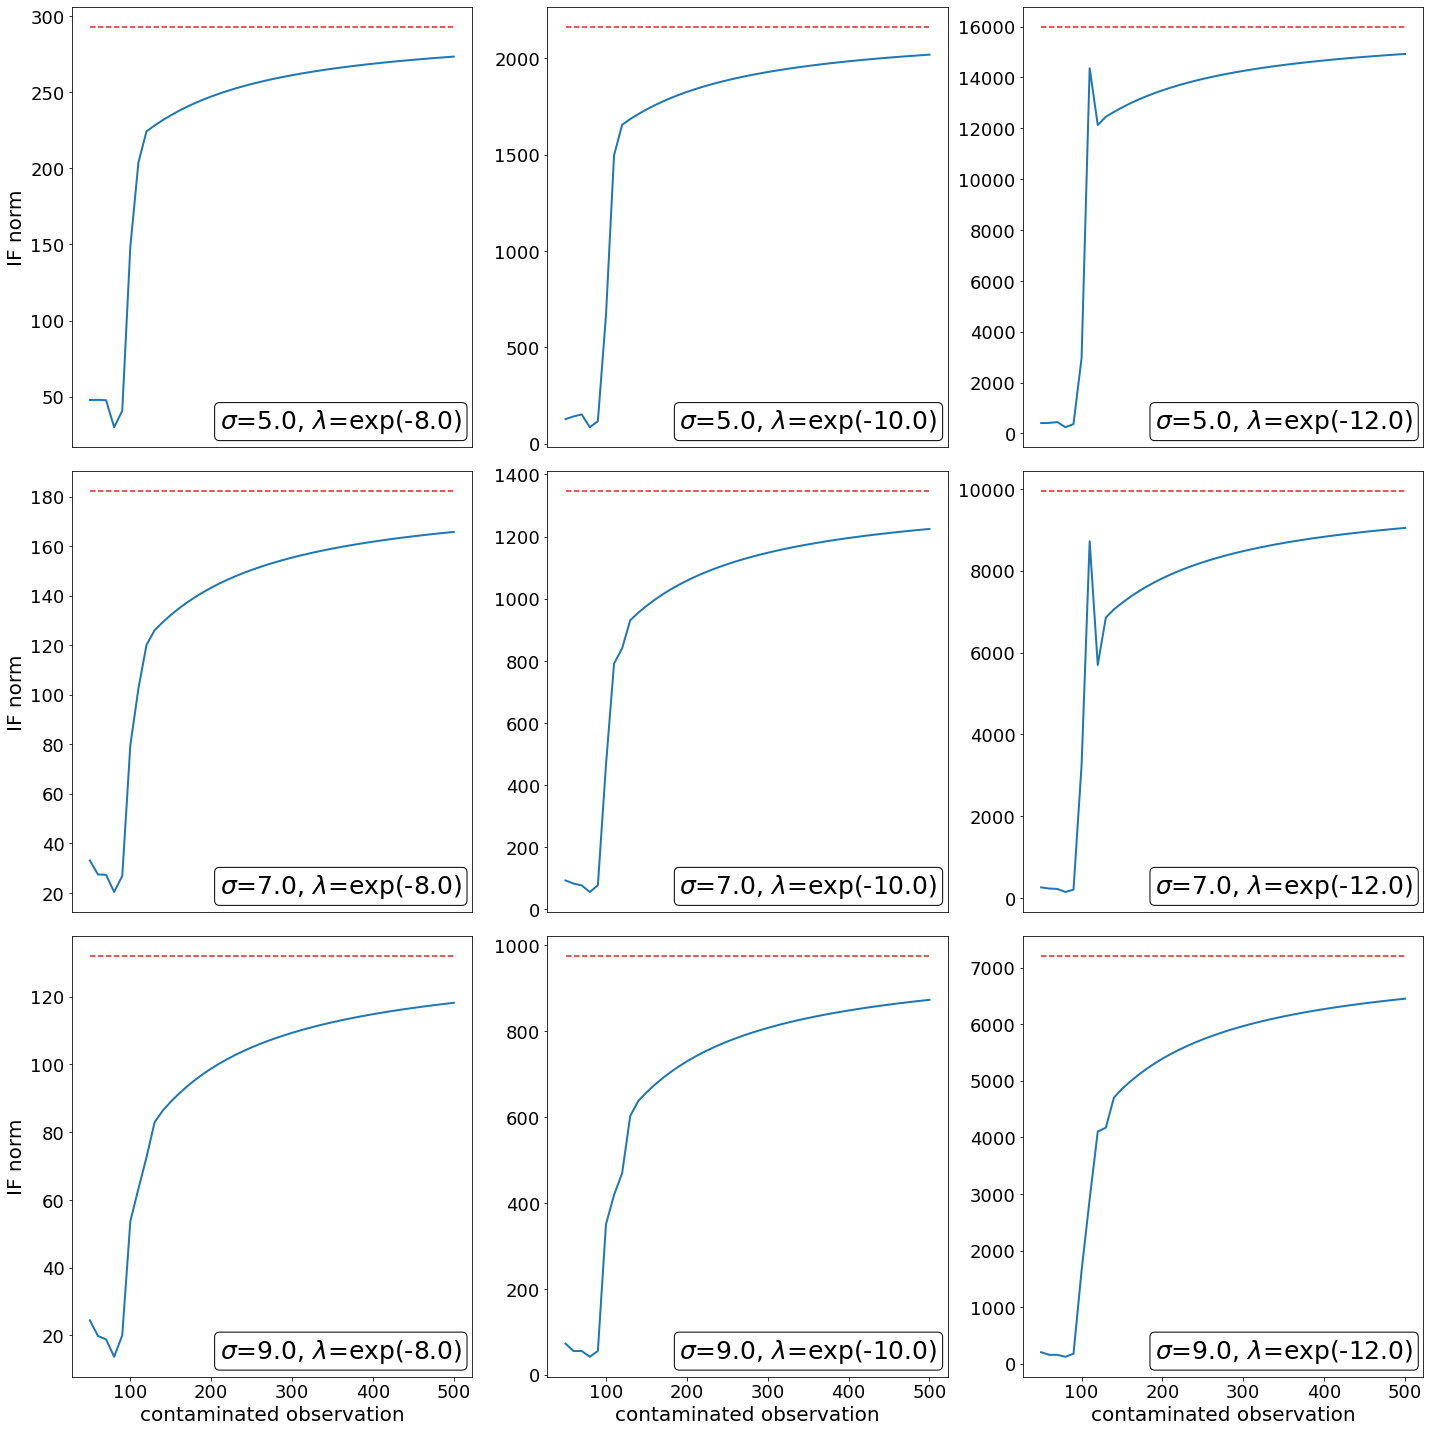

In [2]:
# all together 
output_pd = pd.read_csv('/Users/chenxizhou/Dropbox/code_package/IFdensity/data/natparam_IF_norm_limit.csv')

contam_data_list = np.arange(50., 510., 10)
bw_list = [5., 7., 9.]
log_pen_param_list = [-8., -10., -12.]

fig = plt.figure(constrained_layout=False)
fig.set_figheight(20)
fig.set_figwidth(20)
ncols = 3
nrows = 3

label_fontsize = 20
info_fontsize = 25
tick_fontsize = 18
linewidth = 3.0
x_label = 'contaminated observation'
y_label = 'IF norm'

spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)

for i in range(nrows): 
    for j in range(ncols): 
        
        ax = fig.add_subplot(spec[i, j])
        bw, log_pen_param = bw_list[i], log_pen_param_list[j]
        
        subdf = output_pd[(output_pd.bw == bw_list[i]) & (output_pd.loglambda == log_pen_param_list[j])]
        ax.plot(subdf.contam_data, subdf.IFnorm, color = 'tab:blue', linestyle = 'solid', linewidth = 2)
        ax.plot(subdf.contam_data, subdf.IFnorm_lim, color = 'tab:red', linestyle = 'dashed')
    
        if i == nrows - 1: 
            ax.set_xlabel(x_label, fontsize = label_fontsize)
        else: 
            ax.set_xticks([])
        if j == 0: 
            ax.set_ylabel(y_label, fontsize = label_fontsize)
        
        ax.tick_params(axis = 'both', labelsize = tick_fontsize)

        info = r"$\sigma$={bw}, $\lambda$=exp({pen})".format(bw = bw_list[i], pen = log_pen_param_list[j])
        ax.text(0.975, 0.09,
                info,
                fontsize = info_fontsize,
                multialignment = 'left',
                horizontalalignment = 'right',
                verticalalignment = 'top',
                transform = ax.transAxes,
                bbox = {'facecolor': 'none',
                        'boxstyle': 'Round, pad=0.2'})

plt.tight_layout()
# plt.savefig('/Users/chenxizhou/Dropbox/code_package/IFdensity/plots/geyser-waiting-natparam-IF-norm-limit.pdf')

In [ ]:
# extract the supremum norm of the influence function of log-density 
contam_data_list = np.arange(2., 410., 4).reshape(-1, 1)
bw_list = [5., 7., 9.]
log_pen_param_list = [-8., -10., -12.]

output_pd = pd.DataFrame()

for bw in bw_list: 
    for log_pen_param in log_pen_param_list: 
        
        sup_norm = {}
        
        sup_norm['bw'] = [bw] * len(contam_data_list)
        sup_norm['loglambda'] = [log_pen_param] * len(contam_data_list)
        sup_norm['contam_data'] = contam_data_list.flatten()
        sup_norm['IFsupnorm'] = []
        
        dir_name = (f'/Users/chenxizhou/Dropbox/code_package/IFdensity/data/bw={bw}-' + 
                    f'kernel={kernel_type}-loglambda={log_pen_param}-contamweight={contam_weight}-' + 
                    f'plotdomain={xlimit}-plotcnts={plot_pts_cnt}')
        
        for contam_data in contam_data_list: 
            
            sub_df = np.load(dir_name + f'/contam_data={contam_data}-IF-logden-newdata.npy')
            sup_norm['IFsupnorm'].append(np.max(np.abs(sub_df)))
        
    
        
        output_pd = pd.concat([output_pd, pd.DataFrame(sup_norm)])

output_pd

In [ ]:
output_pd.to_csv('IF-log-density-supnorm.csv')

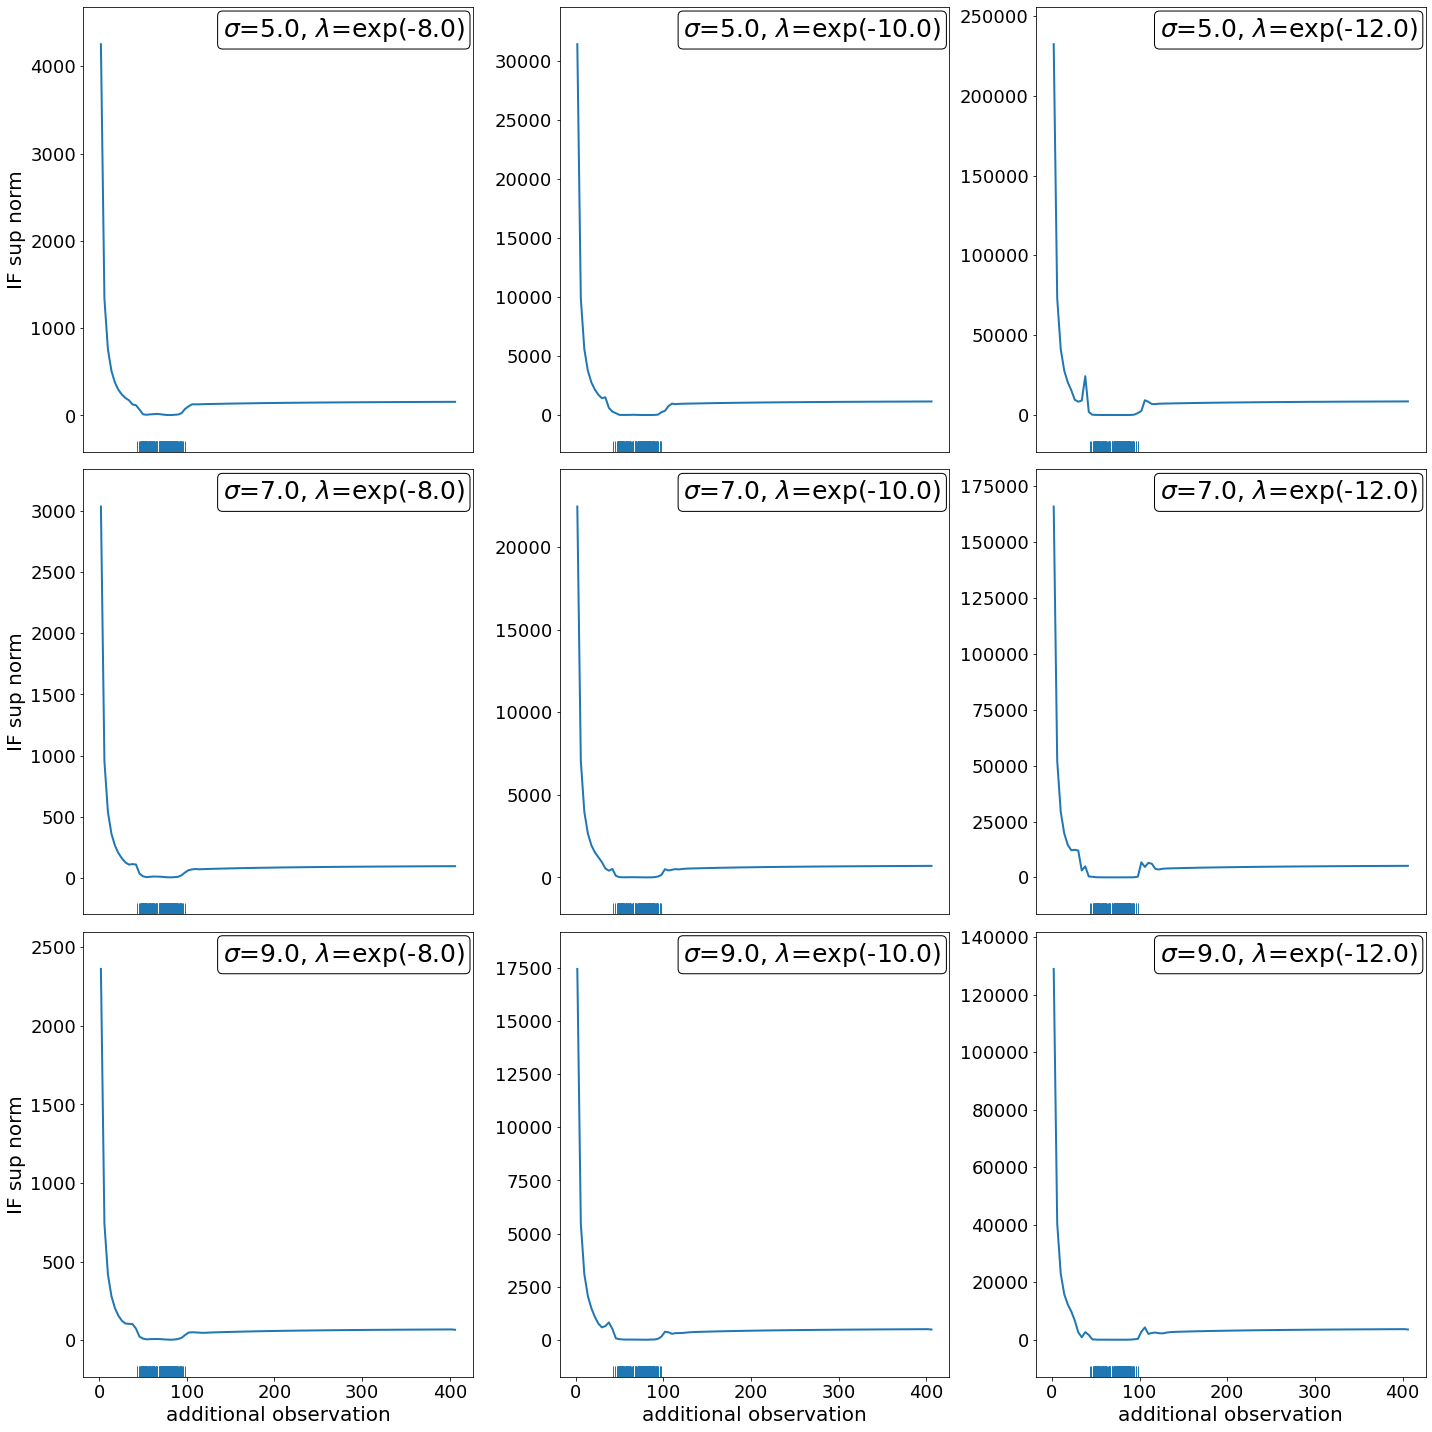

In [3]:
# supremum norm of the influence function of log-density 
output_pd = pd.read_csv('/Users/chenxizhou/Dropbox/code_package/IFdensity/data/IF-log-density-supnorm.csv')

os.chdir('/Users/chenxizhou/Dropbox/code_package/IFdensity')
true_data = np.load('data/geyser.npy').astype(np.float64)
df = copy.deepcopy(true_data[:, 0]).reshape(-1, 1)
data_waiting = df[df != 108.0]

contam_data_list = np.arange(20., 410., 4).reshape(-1, 1)
bw_list = [5., 7., 9.]
log_pen_param_list = [-8., -10., -12.]

xlimit = (1., 410.)
plot_pts_cnt = 3000
kernel_type = 'gaussian_poly2'
contam_weight = 1e-8

fig = plt.figure(constrained_layout=False)
fig.set_figheight(20)
fig.set_figwidth(20)
ncols = 3
nrows = 3

label_fontsize = 20
info_fontsize = 25
tick_fontsize = 18
linewidth = 3.0
x_label = 'additional observation'
y_label = 'IF sup norm'

spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)

for i in range(nrows): 
    for j in range(ncols): 
        
        ax = fig.add_subplot(spec[i, j])
        bw, log_pen_param = bw_list[i], log_pen_param_list[j]
        
        subdf = output_pd[(output_pd.bw == bw_list[i]) & (output_pd.loglambda == log_pen_param_list[j])]
        ax.plot(subdf.contam_data, subdf.IFsupnorm, color = 'tab:blue', linestyle = 'solid', linewidth = 2)
        
        sns.rugplot(data_waiting.flatten(), ax = ax, color = 'tab:blue')
    
        if i == nrows - 1: 
            ax.set_xlabel(x_label, fontsize = label_fontsize)
        else: 
            ax.set_xticks([])
        if j == 0: 
            ax.set_ylabel(y_label, fontsize = label_fontsize)
        
        ax.tick_params(axis = 'both', labelsize = tick_fontsize)

        info = r"$\sigma$={bw}, $\lambda$=exp({pen})".format(bw = bw_list[i], pen = log_pen_param_list[j])
        ax.text(0.98, 0.98,
                info,
                fontsize = info_fontsize,
                multialignment = 'left',
                horizontalalignment = 'right',
                verticalalignment = 'top',
                transform = ax.transAxes,
                bbox = {'facecolor': 'none',
                        'boxstyle': 'Round, pad=0.2'})

plt.tight_layout()
# plt.savefig('/Users/chenxizhou/Dropbox/code_package/IFdensity/plots/geyser-waiting-logdensity-IF-supnorm.pdf')